In [ ]:
import pandas as pd
import numpy as np

financialnews = pd.read_excel('yahoo_finance_results.xlsx')
financialnews["title_summary"] = financialnews["title"] + ": " + financialnews["summary"]
financialnews["time_without_source"] = financialnews["time"].apply(lambda x: x.split("•")[-1].strip())

model_ollama = "unsloth.Q4_K_M" 
def build_prompt(texts):

    predict_instructions = """
You are a sentiment score prediction model. You will be given a news title and summary from financial news, and your task is to predict the sentiment score of each sentence.
You must only output only one score from 1 to 12 (1 means confusion and 12 means excitement). Do not provide any additional information or explanation. Just output the sentiment score as a number.
    """

    prompt = predict_instructions + "\n\n"

    for text in texts:
        prompt += f"Text: {text}\nScore: \n" 

    return prompt

def classify_with_llm(test_text, prompt_base):

    response = None
    max_attempts = 5  
    attempt_count = 0  

    def is_number(s):
        try:
            float(s)  
            return True
        except ValueError:
            return False

    while (not response or not is_number(response)) and attempt_count < max_attempts:
        attempt_count += 1 
        full_prompt = f"{prompt_base}\nClassification:\nText: {test_text}\nScore: "

        result = ollama.chat(model=model_ollama, messages=[
            {'role': 'user', 'content': full_prompt}
        ])
        
        response = result['message']['content'].strip()
        response = response.split()[0] if response.split() else ""  
        
        print(f"Attempt {attempt_count}: Received response '{response}'")  

        if attempt_count >= max_attempts: 
            print(f"Failed to get a valid response after {max_attempts} attempts. Returning None.")
            return None  

    return float(response) if is_number(response) else None  



def predict_sentiment(financialnews):

    predictions_list = []

    for days in range(30, 1, -1): 
        day_str = f"{days} days ago"
        df_day = financialnews[financialnews["time_without_source"] == day_str]
        texts = df_day["title_summary"].tolist()
        
        if texts:
            prompt_base = build_prompt(texts)

            for text in texts:
                predicted_score = classify_with_llm(text, prompt_base)
                predictions_list.append({
                    "financialnews": text,
                    "day": day_str,
                    "score": predicted_score
                })

    return pd.DataFrame(predictions_list)

predictions_df = predict_sentiment(financialnews)

print(predictions_df)

Attempt 1: Received response '11'
Attempt 1: Received response '8'
Attempt 1: Received response '12'
Attempt 1: Received response '2'
Attempt 1: Received response '11'
Attempt 1: Received response '4'
Attempt 1: Received response '12'
Attempt 1: Received response '8'
Attempt 1: Received response '7'
Attempt 1: Received response '4'
Attempt 1: Received response '12'
Attempt 1: Received response '8'
Attempt 1: Received response '11'
Attempt 1: Received response '11'
Attempt 1: Received response '12'
Attempt 1: Received response '6'
Attempt 1: Received response '12'
Attempt 1: Received response '9'
Attempt 1: Received response '7'
Attempt 1: Received response '2'
Attempt 1: Received response '8'
Attempt 1: Received response '8'
Attempt 1: Received response '9'
Attempt 1: Received response '8'
Attempt 1: Received response '8'
Attempt 1: Received response '8'
Attempt 1: Received response '8'
Attempt 1: Received response '9'
Attempt 1: Received response '11'
Attempt 1: Received response '12'

In [ ]:
today = pd.to_datetime("2025-02-17")  

predictions_df["day_numeric"] = predictions_df["day"].str.extract(r'(\d+)').astype(int)

predictions_df["actual_date"] = today - pd.to_timedelta(predictions_df["day_numeric"], unit="D")

average_scores = predictions_df.groupby("actual_date")["score"].mean().reset_index()
average_scores = average_scores.sort_values(by="actual_date", ascending=False)

print(average_scores)

   actual_date      score
27  2025-02-15   7.888889
26  2025-02-14   9.222222
25  2025-02-13   8.000000
24  2025-02-12   9.800000
23  2025-02-11   7.083333
22  2025-02-09   8.250000
21  2025-02-08   7.000000
20  2025-02-07   5.500000
19  2025-02-06   8.600000
18  2025-02-05   6.500000
17  2025-02-04   8.363636
16  2025-02-03   9.500000
15  2025-02-02   9.500000
14  2025-02-01   9.333333
13  2025-01-31   9.500000
12  2025-01-30   9.000000
11  2025-01-29   8.857143
10  2025-01-28   9.300000
9   2025-01-27  10.000000
8   2025-01-26   9.500000
7   2025-01-25   6.000000
6   2025-01-24   7.714286
5   2025-01-23   9.600000
4   2025-01-22   8.333333
3   2025-01-21   6.800000
2   2025-01-20  10.000000
1   2025-01-19  10.500000
0   2025-01-18   7.900000


In [10]:
describe_stats = average_scores['score'].describe()
describe_stats

count    28.000000
mean      8.483792
std       1.301607
min       5.500000
25%       7.845238
50%       8.728571
75%       9.500000
max      10.500000
Name: score, dtype: float64

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ticker = "TSM"  
start_date = "2025-01-17"
end_date = "2025-02-17"

df = yf.download(ticker, start=start_date, end=end_date)


[*********************100%***********************]  1 of 1 completed


In [67]:
df = pd.read_excel("df.xlsx")

In [ ]:
df = df.set_index("Date")  

In [ ]:
merged_df = df.join(average_scores, how="left")  

In [70]:
merged_df

,Close,High,Low,Open,Volume,score
Date,,,,,,
2025-01-17,211.500000,215.679993,211.059998,215.169998,21606100,NaN
2025-01-21,218.699997,220.149994,212.050003,214.460007,19061300,6.800000
2025-01-22,223.199997,225.429993,219.309998,221.949997,17294500,8.333333
2025-01-23,224.619995,224.699997,219.410004,220.100006,8986800,9.600000
2025-01-24,221.880005,226.399994,220.960007,226.220001,13183800,7.714286
2025-01-27,192.309998,207.000000,187.669998,197.039993,68667500,10.000000
2025-01-28,202.399994,202.839996,192.460007,195.649994,31738800,9.300000
2025-01-29,202.330002,206.449997,199.750000,204.490005,15199500,8.857143
2025-01-30,208.149994,209.619995,205.419998,206.570007,13539000,9.000000


In [71]:
merged_df["score"] = merged_df["score"].fillna(0)

In [ ]:
merged_df

,Date,Close,High,Low,Open,Volume,score
0,2025-01-17,211.500000,215.679993,211.059998,215.169998,21606100,0.000000
1,2025-01-21,218.699997,220.149994,212.050003,214.460007,19061300,6.800000
2,2025-01-22,223.199997,225.429993,219.309998,221.949997,17294500,8.333333
3,2025-01-23,224.619995,224.699997,219.410004,220.100006,8986800,9.600000
4,2025-01-24,221.880005,226.399994,220.960007,226.220001,13183800,7.714286
5,2025-01-27,192.309998,207.000000,187.669998,197.039993,68667500,10.000000
6,2025-01-28,202.399994,202.839996,192.460007,195.649994,31738800,9.300000
7,2025-01-29,202.330002,206.449997,199.750000,204.490005,15199500,8.857143
8,2025-01-30,208.149994,209.619995,205.419998,206.570007,13539000,9.000000
9,2025-01-31,209.320007,215.000000,208.199997,209.929993,15781900,9.500000


In [ ]:
merged_df['score'].describe()

count    20.000000
mean      7.583698
std       2.858207
min       0.000000
25%       7.012500
50%       8.481818
75%       9.350000
max      10.000000
Name: score, dtype: float64

In [ ]:
#8.4818
#-7613.359
midean = 8.481818
merged_df["signal"] = 0
merged_df.loc[(merged_df['score']> midean) & (merged_df['score'].shift(1) < midean) , "signal"] = 1
merged_df.loc[(merged_df['score']< midean) & (merged_df['score'].shift(1) > midean) , "signal"] = -1

In [ ]:
merged_df["Date"] = pd.to_datetime(merged_df["Date"])  
merged_df = merged_df.set_index("Date")

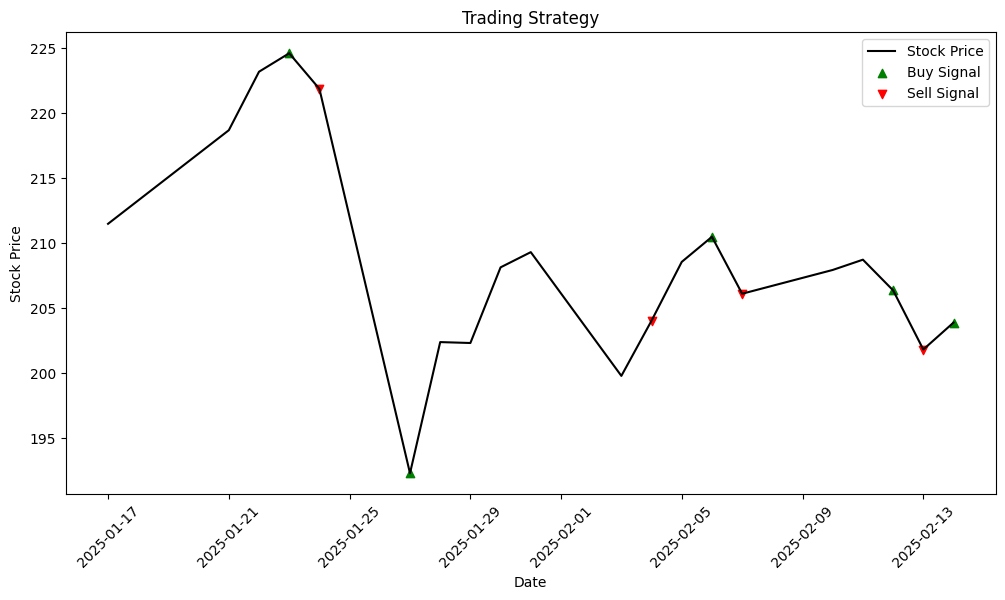

In [ ]:
plt.figure(figsize=(12,6))

plt.plot(merged_df.index, merged_df["Close"], label="Stock Price", color="black")

plt.scatter(merged_df.index[merged_df["signal"] == 1], 
            merged_df["Close"][merged_df["signal"] == 1], 
            label="Buy Signal", marker="^", color="green", alpha=1)

plt.scatter(merged_df.index[merged_df["signal"] == -1], 
            merged_df["Close"][merged_df["signal"] == -1], 
            label="Sell Signal", marker="v", color="red", alpha=1)

plt.legend()
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Trading Strategy")
plt.xticks(rotation=45)  
plt.show()


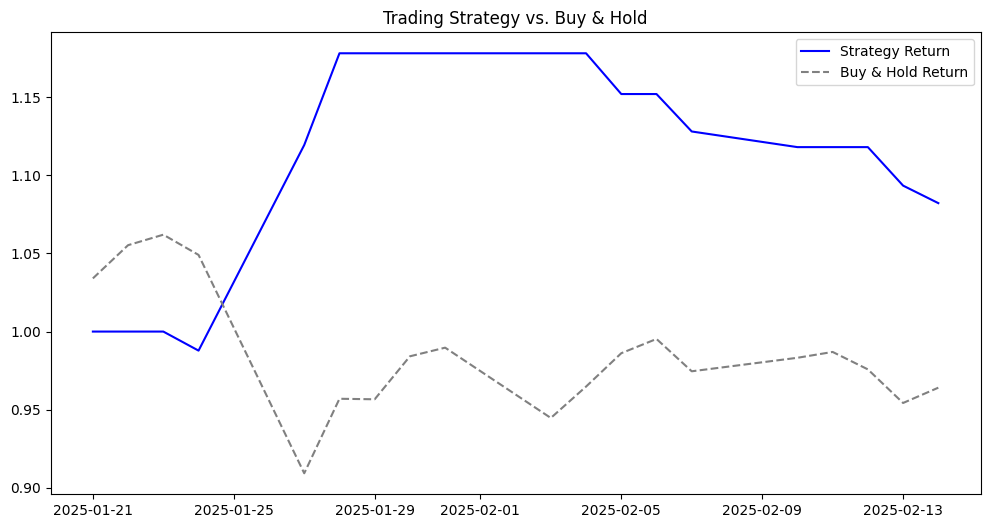

Date
2025-01-17         NaN
2025-01-21    1.000000
2025-01-22    1.000000
2025-01-23    1.000000
2025-01-24    0.987802
2025-01-27    1.119446
2025-01-28    1.178181
2025-01-29    1.178181
2025-01-30    1.178181
2025-01-31    1.178181
2025-02-03    1.178181
2025-02-04    1.178181
2025-02-05    1.152082
2025-02-06    1.152082
2025-02-07    1.128110
2025-02-10    1.118094
2025-02-11    1.118094
2025-02-12    1.118094
2025-02-13    1.093444
2025-02-14    1.082230
Name: Strategy Return, dtype: float64 Date
2025-01-17         NaN
2025-01-21    1.034043
2025-01-22    1.055319
2025-01-23    1.062033
2025-01-24    1.049078
2025-01-27    0.909267
2025-01-28    0.956974
2025-01-29    0.956643
2025-01-30    0.984161
2025-01-31    0.989693
2025-02-03    0.944681
2025-02-04    0.964775
2025-02-05    0.986147
2025-02-06    0.995272
2025-02-07    0.974563
2025-02-10    0.983215
2025-02-11    0.986950
2025-02-12    0.975792
2025-02-13    0.954279
2025-02-14    0.964066
Name: Daily Return, dtype: float

In [ ]:
merged_df["Daily Return"] = merged_df["Close"].pct_change()
merged_df["Strategy Return"] = merged_df["signal"].shift(1) * merged_df["Daily Return"]

cumulative_return = (1 + merged_df["Strategy Return"]).cumprod()
buy_and_hold_return = (1 + merged_df["Daily Return"]).cumprod()
plt.figure(figsize=(12,6))
plt.plot(cumulative_return, label="Strategy Return", color="blue")
plt.plot(buy_and_hold_return, label="Buy & Hold Return", color="gray", linestyle="dashed")
plt.legend()
plt.title("Trading Strategy vs. Buy & Hold")
plt.show()

print(cumulative_return, buy_and_hold_return)